# Проверка гипотез по увеличению выручки в интернет-магазине — оценка результаты A/B теста

## Введение 

Для любой компании важно улучшать свои бизнес-метрики. В нашем интеренет-магазине, совместно с отделом маркетинга, мы подготовили список гипотез для улучшения наших бизнес-метрик.
<br>В данной работе мы выберем наиболее приоритетные гипотезы,а в дальнейшем, разберем результаты проведенного A/B теста.

## Изучение и предобработка данных

Для анализа у нас имеются три датафрейма. Для начала импортируем необходимые для анализа библиотеки и изучим полученные таблицы.

In [ ]:
#импорт библиотек
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
pd.options.display.float_format = '{: .2f}'.format
pd.set_option('display.max_colwidth', None)

import plotly.io as pio
pio.renderers.default = "png"

In [ ]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Изучим подробнее информацию о датафреймах.

In [ ]:
#вывод основной информации о таблицах
hypothesis.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

Для начала заменим в таблице `hypothesis` наименование столбцов на нижний регистр, а так же в таблице `orders` переименуем пару столбцов под змеиный регистр.

In [ ]:
#переименование столбцов
hypothesis.columns = [x.lower() for x in hypothesis.columns]
orders = orders.rename(columns={'transactionId': 'transaction_id','visitorId': 'visitor_id'}) 


В таблицах `orders` и`visitors` есть столбцы с датами, но в обоих таблицах не верный тип данных. Приведем даты к типу данных `datetime`.

In [ ]:
#изменение типа данных на datetime
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
    
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)


Проверим нет ли явных дубликатов в таблицах.

In [ ]:
orders.duplicated().sum()

0

In [ ]:
visitors.duplicated().sum()

0

И в таблице `orders` и в `visitors` явных дубликатов нет.
<br>Посмотрим сколько какие уникальные значения попадаются у нас в таблице `visitors`, в столбце `group` и удостоверимся, что группы у нас только две.

In [ ]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

Теперь посмотрим, если ли пользователи, которые попали одновременно в обе группы.

In [ ]:
len(np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), orders.query('group == "B"')['visitor_id'].unique()))

58

Мы видим, что 58 `visitor_id` встречаются в обеих группах, но мы не будем удалять эти данные, т.к. в дальнейшем мы будем анализировать не действия конкретных пользователей, а отдельные сессии этих пользователей. И если пользователь попал в обе группы, то это значит, что именно сессии делили на группы, а не пользователей.

## Приоритизация гипотез

Для приоритизации гипотез будем использовать два способа **ICE** и **RICE**.
<br> Выведем таблицу со списком гипотез.

In [ ]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Всего у нас 9 гипотез. Для каждой гипотезы есть свои оценки(от 1 до 10) по четырем компонентам:
 - reach — скольких пользователей затронет изменение;
 - impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
 - confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
 - efforts — сколько стоит протестировать эту гипотезу.

### ICE

Для способа **ICE** нам понадобятся только три компонента.
<br>**ICE** считается по формуле:
$$\frac{impact × confidence}{efforts}$$

In [ ]:
#расчет ICE
hypothesis['ICE'] =  (hypothesis['impact']  * hypothesis['confidence']) / hypothesis['efforts']

hypothesis[['hypothesis','ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Итак, наибольшую приоритетность при получили гипотезы с индексами *8, 0 и 7*

### RICE

**RICE** находится по формуле: 
$$\frac{impact × confidence × confidence}{efforts}$$

In [ ]:
#расчет RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) /hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


При расчете способом **RICE**, самыми приоритетными оказались гипотезы с индексами *7, 2 и 0*.

### Вывод

Первые тройки лидеров у методов приоритизации **ICE** и **RICE** отличаются. Это происходит из-за того, что при использовании второго способа так же учитывается охват.
<br>Однако, и и в первом случае и во втором, в топ-3 вошли гипотезы с индексами *7 и 0*. Именно на них стоитт обратить внимание в первую очередь.

## Анализ A/B-теста

### Кумулятивные метрики

#### График кумулятивной выручки по группам

Построим график кумулятивной выручки по группам.

        date group  transaction_id  buyers  revenue  visitors
0 2019-08-01     A              24      20   148579       719
1 2019-08-01     B              21      20   101217       713
2 2019-08-02     A              44      38   242401      1338
3 2019-08-02     B              45      43   266748      1294
4 2019-08-03     A              68      62   354874      1845


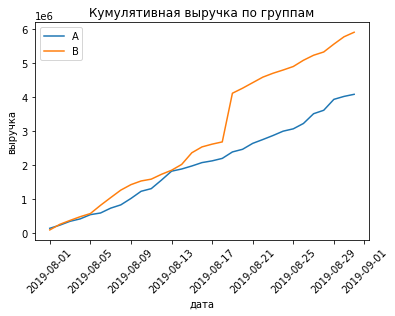

In [ ]:
#Создаем датафрейм dates_groups с уникальными парами значений 'date' и 'group'
dates_groups = orders[['date', 'group']].drop_duplicates()

# расчет суммы средних чеков
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transaction_id' : pd.Series.nunique,
'visitor_id' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

#расчет агрегированныч кумулятивных данных о посетителях по дням 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].
        agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
#объединяем кумулятивные данные
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'transaction_id', 'buyers', 'revenue', 'visitors']


print(cumulative_data.head(5))
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group'] =='A'][['date','revenue', 'transaction_id']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group'] =='B'][['date','revenue', 'transaction_id']]

#построение графика выручки групп А и B
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label = 'A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label = 'B')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Кумулятивная выручка по группам")
plt.xlabel("дата")
plt.ylabel("выручка")
plt.show()

Выручка почти равномерно увеличивается в течение всего теста.Выручка в группе **B** стабильно выше на протяжении всего теста.
<br> В группе **B** наблюдается резкий рост с 19 августа 2019г. Скорее всего на этот скачек повлияли аномалии в данных.<br> Посмотрим 5 самых дорогих заказов в группе **B** за 19 августа. А так же найдем медиальное значение за эту же дату.

In [ ]:
orders.query('date == "2019-08-19" & group == "B"').sort_values(by='revenue', ascending=False).head(5)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
527,1570513684,2837914161,2019-08-19,33405,B
461,2683113224,154576532,2019-08-19,26550,B
368,3268879337,2536252163,2019-08-19,20026,B
463,4170537404,290022471,2019-08-19,16480,B


In [ ]:
orders.query(' date == "2019-08-19" ')['revenue'].median()

2630.0

Мы видим, что 19 августа 19 года самый дорогой заказ составил почти 1,3 млн., тогда как медиана составляет всего 2,6 тыс. Разница довольно велика. Это подтверждает, что рост выручки 19 августа произошел из-за аномального заказа.

#### График кумулятивного среднего чека по группам

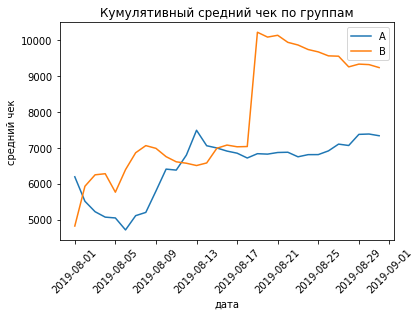

In [ ]:
# построение графиков среднего чека по группам
plt.plot(cumulative_revenue_A['date'],cumulative_revenue_A['revenue']/cumulative_revenue_A['transaction_id'],label = 'A')
plt.plot(cumulative_revenue_B['date'],cumulative_revenue_B['revenue']/cumulative_revenue_B['transaction_id'],label = 'B')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Кумулятивный средний чек по группам")
plt.xlabel("дата")
plt.ylabel("средний чек")
plt.show()

Средний чек обеих групп сильно коллеблется по 13 августа 19 года.  Далее по группе **А** заметно выравнивание, а из-за найденной выше аномалии в группе **В** 19 августа видер резкий рост. На протяжении почти всего теста средний чек группы **B** выше, чем у группы **A**.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

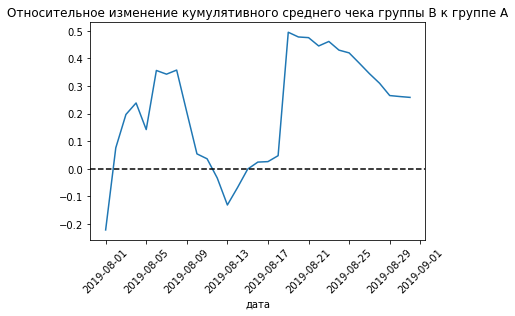

In [ ]:
#собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B,left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'],(merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['transaction_idB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['transaction_idA'])-1)
plt.xticks(rotation = 45)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title("Относительное изменение кумулятивного среднего чека группы B к группе A")
plt.xlabel("дата")
plt.show()

С 1 августа 19 года, на графике, мы наблюдаем рост среднего чека по группе **B**. Уже на второй день средний чек по группе **B** превзошел средний чек по группе **A**. Рост продолжался до 7 августа 19 года. Далее мы наблюдаем спад суммы среднего чека и новый рост 19 августа 19 года за счет найденной нами ранее аномалии.
<br>На графике мы видим значительные коллебания, что говорит о имеющихся в данных аномалиях. 

#### График кумулятивной конверсии по группам

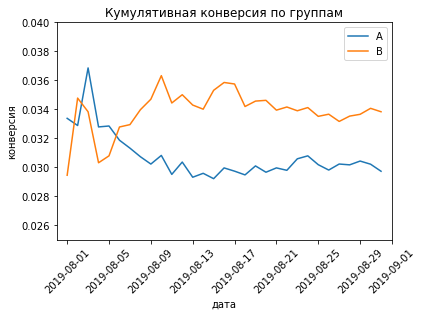

In [ ]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['transaction_id']/ cumulative_data['visitors']

#разделяем группы
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B']
plt.plot(cumulative_revenue_A['date'],cumulative_revenue_A['conversion'], label = 'A')
plt.plot(cumulative_revenue_B['date'],cumulative_revenue_B['conversion'], label = 'B')
plt.legend()
plt.xticks(rotation = 45)
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), 0.025, 0.04])
plt.title("Кумулятивная конверсия по группам")
plt.xlabel("дата")
plt.ylabel("конверсия")
plt.show()

На графике мы видим, что в начале теста большая конверсия была в группе **A**, однако, с 6 августа ситуация меняется и до конца теста лидирует группа **B**.

#### График относительного изменения кумулятивной конверсии группы B к группе A

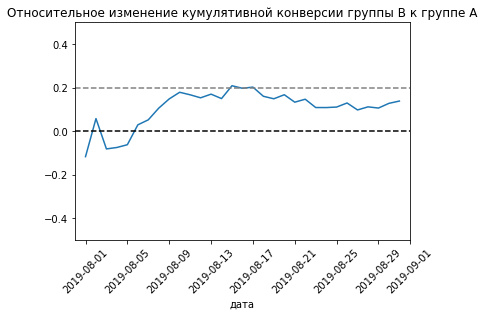

In [ ]:
#собираем данные в одном датафрейме
merged_cumulative_conversions = cumulative_revenue_A[['date','conversion']].merge(cumulative_revenue_B[['date','conversion']], left_on = 'date', right_on = 'date',  how='left', suffixes=['A', 'B'])
# cтроим отношение средних чеков
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.xticks(rotation = 45)
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), -0.5, 0.5])
plt.title("Относительное изменение кумулятивной конверсии группы B к группе A")
plt.xlabel("дата")
plt.show()

Конверсия группы **B** превысила конверсию группы **A** 6 августа 19 года. С того момента группа **A** ни разу не смогла превысить показатели конверсии группы **B**.C 15 августа по 18 августа разница достигает 20%.
<br>Конверсия группы **B** стабильно лучше, чем  вгруппе **A**.

### Анализ выбросов и всплесков

По графикам мы узнали, что в данных есть аномалии, найдем их.

#### Точечный график количества заказов по пользователям

Оценим количество заказов с помощью точечного графика

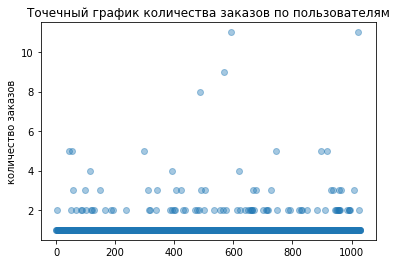

In [ ]:

orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users.columns = ['visitor', 'transaction']
orders_by_users.sort_values(by='transaction',ascending=False)
#print(orders_by_users.head(10))
x_values = pd.Series(range(0, len(orders_by_users)))

plt.scatter(x_values, orders_by_users['transaction'],alpha = 0.4) 
plt.title("Точечный график количества заказов по пользователям")
plt.ylabel("количество заказов")

plt.show()

На графике видно, что пользователей совершивших более 2х заказов не так много.<br>Найдем 95 и 99 перцентили

In [ ]:
#методом np.percentile('column', [percentile1, percentile2]) находим перцентили
np.percentile(orders_by_users['transaction'], [95, 99])


array([2., 4.])

Итак, пользователей, кто совершил более 2 заказов не более 5% от всего количества.

#### Точечный график количества заказов по стоимости заказов

По аналогии построим точечный график по стоимости заказов.

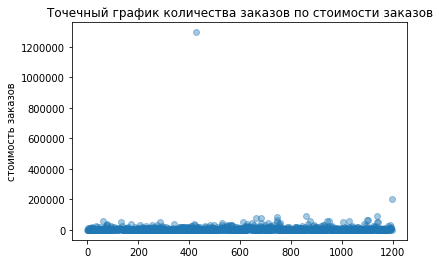

In [ ]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'],alpha = 0.4)
plt.ticklabel_format(style='plain')
plt.title("Точечный график количества заказов по стоимости заказов")
plt.ylabel("стоимость заказов")
plt.show()
#точечная диаграмма стоимостей заказов

На графике четко видно уже замеченную нами аномалию в 1.3 млн. Укрупним диаграмму.

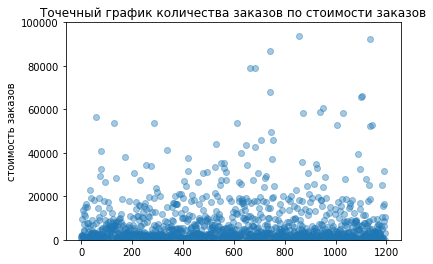

In [ ]:
plt.scatter(x_values, orders['revenue'],alpha = 0.4)
plt.ylim([0, 100000])
plt.title("Точечный график количества заказов по стоимости заказов")
plt.ylabel("стоимость заказов")
plt.show()

Мы видим, что заказов более 30 тыс. уже не очень много. Найдем 95 и 99 перцентили, что бы более точно определить суммы, которые можно принять за выбросы.

In [ ]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Итак, заказов на сумму более 28 тыс. менее 5% от всего количества.

###  Статистическую значимость различий в конверсии между группами по «сырым» данным

Проверим статистическую значимость различий в конверсии между группами по данным с аномалиями. 

In [ ]:
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']
#количество пользователей до выбранной даты включительно в группе A
visitors_A_сummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_сummulative.columns = ['date', 'visitors_cummulative_A']


visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']
#количество пользователей до выбранной даты включительно в группе B
visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

#количество и сумма заказов в выбранную дату в группе A
orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']
#orders_A_daily
orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values('date')
orders_A_cummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A',
]


#количество и сумма заказов в выбранную дату в группе B
orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values('date')
orders_B_cummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B',
]
#объединение таблиц
data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_сummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)
data.head(5)

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Мы получили таблицу `data` с необходимыми нам данными для дальнейшего анализа.


<br> Сформулируем гипотезы:
<br>*H₀*: Статистически значимых различий в конверсии между группами нет.
<br>*H₁*: Различия в конверсиях между круппами статистически значимы.

In [ ]:
#создение переменныч orders_by_users_A и orders_by_users_B,
#них для пользователей,которые сделали заказ, укажем число совершённых заказов
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor', 'transaction']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor', 'transaction']

#переменные, с данными о количестве заказов пользователей по группе
sampleA = pd.concat(
    [
        orders_by_users_A['transaction'],
        pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['transaction'])),
                  name='transaction')
    ],
    axis=0
)

sampleB = pd.concat(
    [
        orders_by_users_B['transaction'],
        pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['transaction'])), 
                  name='transaction')
    ],
    axis=0
)

#расчет p-value  
display('alpha = 0.05')
display('p-value = {0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
#относительный прирост среднего числа заказов группы B
display('Относительный показатель B и A = {0:.3f}'.format(sampleB.mean()/sampleA.mean()-1)) 

'alpha = 0.05'

'p-value = 0.017'

'Относительный показатель B и A = 0.138'

0.017 < 0.05 Отвергаем нулевую гипотезу: разница статистически значима. Относительный выйгрыш группы **B** над группой **A** равен 13.8%.

### Cтатистическую значимость различия средних чеков между группами по "сырым" данным

Проверим статистическую значимость различия средних чеков между группами по данным с аномалиями.
Сформулируем гипотезы:
<br>*H₀*: Статистически значимых различий средних чеков  между группами нет. <br>*H₁*: Различия в среднийх чеках между группами статистически значимы.

In [ ]:
display("alpha = 0.05")
display('p-value = {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]),)
display('Относительный показатель B и A = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

'alpha = 0.05'

'p-value = 0.729'

'Относительный показатель B и A = 0.259'

*P-value* = 0.729 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, не отвергаем. Однако относительный выйгрыш группы B равен 25.9%.

###  Статистическую значимость различий в конверсии между группами по «очищенным» данным

Проведем аналогичный анализ уже по "очищенным" данным.

In [ ]:
#исключаем выбросы по количеству заказов пользователя
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['transaction'] > 2]['visitor'],
        orders_by_users_B[orders_by_users_B['transaction'] > 2]['visitor'],
    ],
    axis=0,
)
#исключаем выбросы по сумме заказа
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
len(abnormal_users)

74

Строк содержащих выбросы оказалось 74.
<br>Повторим гипотезы:
<br>
<br>*H₀*: Статистически значимых различий в конверсии между группами нет.
<br>*H₁*: Различия в конверсиях между круппами статистически значимы.
<br>
<br>Найдем *p-value*:

In [ ]:
sample_A_filter = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor'].isin(abnormal_users))
        ]['transaction'],
        pd.Series(
            0,
            index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['transaction'])),
                  name='transaction'
        ),
    ],
    axis=0,
)

sample_B_filter = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor'].isin(abnormal_users))
        ]['transaction'],
        pd.Series(
            0,
            index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['transaction'])),
                  name='transaction',
        ),
    ],
    axis=0,
)
display('alpha = 0.05')
display('p-value = {0:.3f}'.format(st.mannwhitneyu(sample_A_filter, sample_B_filter,alternative = 'two-sided')[1]))
display('Относительный показатель B и A = {0:.3f}'.format(sample_B_filter.mean()/sample_A_filter.mean()-1))

'alpha = 0.05'

'p-value = 0.013'

'Относительный показатель B и A = 0.173'

0.013 < 0.05 Отвергаем нулевую гипотезу: разница статистически значима. Относительный выйгрыш группы **B** над группой **A** равен 17.3%. 
<br><br>
Даже после "очистки" данных разница статестически значима. Относительный выйгрыш группы **B** над группой **A** высор на 3.5%.
<br>Теперь проверим разницу между средними чеками.
<br> Повторим гипотезы:
<br>
<br>*H₀*: Статистически значимых различий средних чеков  между группами нет. <br>*H₁*: Различия в среднийх чеках между группами статистически значимы.

In [ ]:
display("alpha = 0.05")
display('p-value = {0:.3f}'.format(st.mannwhitneyu(
    orders[
        np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)),
)
    ]['revenue'],orders[
    np.logical_and(
        orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)),
)
        ]['revenue'],alternative = 'two-sided')[1])
)
display('Относительный показатель B и A = {0:.3f}'.format(orders[np.logical_and(orders['group'] == 'B',
    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
)
    ]['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A',
    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
)
    ]['revenue'].mean()- 1)
)

'alpha = 0.05'

'p-value = 0.738'

'Относительный показатель B и A = -0.020'

*P-value* = 0.738 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, не отвергаем, как и в случае с "сырыми" данными. А вот средний чек группы **B** в "очищенных" данных оказался на 2% меньше, чем в группе "A".Напомню, что в "сырых" данных группа **B** выигрывала на 25,9%

## Вывод

После анализа предоставленных данных по проводимому A/B-тесту, мы можем сделать вывод, что несмотря на незначительный проигрыш в средних чеках, группа **B** значительно эффективней в конверсии, чем группа **A**.
<br>**Принятое решение**:
<br>Остановить тест, зафиксировать победу группы **B**.
